# Notes on Chapter 3 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
from math import pi
tfd = tfp.distributions
tfm = tf.math

In [2]:
%load_ext rpy2.ipython

### 3.1

In [3]:
%%R

Pr_Positive_Vampire <- 0.95
Pr_Positive_Mortal <- 0.01
Pr_Vampire <- 0.001
Pr_Positive <- Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive <- Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

[1] 0.08683729


There's no advantage to using tensorflow if we're just using python as a calculator, so the python code is virtually identical to the R code:

In [4]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
Pr_Positive = Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

0.08683729433272395

### 3.2

In [5]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prob_p <- rep(1, 1000)
prob_data <- dbinom(6, size=9, prob=p_grid)
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)

In [6]:
p_grid = tf.linspace(0., 1., 1000)
prob_p = tf.ones_like(p_grid)
prob_data = tfd.Binomial(9, probs=p_grid).prob(6)
posterior = prob_data * prob_p
posterior = posterior / tfm.reduce_sum(posterior)

### 3.3

In [7]:
%%R

samples <- sample(p_grid, prob=posterior, size=1e4, replace=TRUE)

In [8]:
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

### 3.4

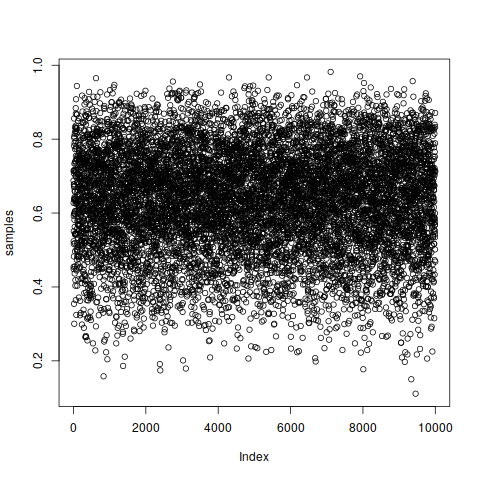

In [9]:
%%R

plot(samples)

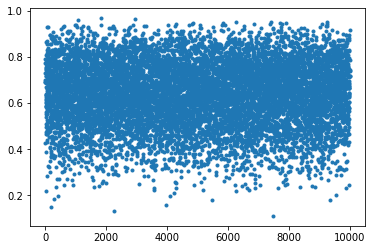

In [10]:
plt.plot(samples, '.');

### 3.5

R[write to console]: Loading required package: rstan

R[write to console]: Loading required package: StanHeaders

R[write to console]: Loading required package: ggplot2

R[write to console]: rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

R[write to console]: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: dagitty

R[write to console]: rethinking (Version 2.01)

R[write to console]: 
Attaching package: ‘rethinking’


R[write to console]: The following object is masked from ‘package:stats’:

    rstudent




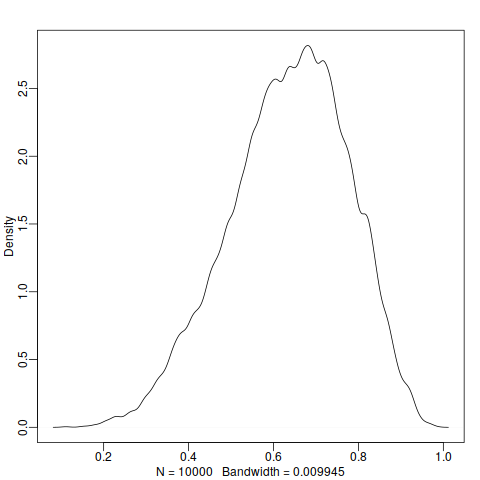

In [11]:
%%R

library(rethinking)
dens(samples)

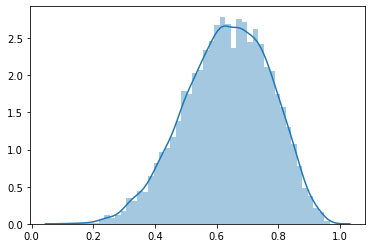

In [12]:
sns.distplot(samples)

### 3.6

In [13]:
%%R

sum(posterior[p_grid < 0.5])

[1] 0.1718746


In [14]:
tf.reduce_sum(posterior[p_grid < 0.5])

<tf.Tensor: shape=(), dtype=float32, numpy=0.17187457>

### 3.7

In [15]:
%%R

sum(samples < 0.5) / 1e4

[1] 0.1729


In [16]:
tf.reduce_sum(tf.cast(samples < 0.5, tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.1718>

### 3.8

In [17]:
%%R

sum(samples > 0.5 & samples < 0.75) / 1e4

[1] 0.6098


In [18]:
tf.reduce_sum(tf.cast(tf.logical_and(samples > 0.5, samples < 0.75), tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.6073>

### 3.9

In [19]:
%%R

quantile(samples, 0.8)

      80% 
0.7587588 


In [20]:
tfp.stats.percentile(samples, 80)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7587587>

### 3.10

In [21]:
%%R

quantile(samples, c(0.1, 0.8))

      10%       80% 
0.4453453 0.7587588 


In [22]:
tfp.stats.percentile(samples, (10, 80))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.44944945, 0.7587587 ], dtype=float32)>

### 3.11

In [23]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1, 1000)
likelihood <- dbinom(3, size=3, prob=p_grid)
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample(p_grid, size=1e4, replace=TRUE, prob=posterior)

In [24]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(3, probs=p_grid).prob(3)
posterior = likelihood * prior
posterior = posterior / tfm.reduce_sum(posterior)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

### 3.12

In [25]:
%%R

PI(samples, prob=0.5)

      25%       75% 
0.7077077 0.9289289 


Since we don't have a python version of the author's library (yet), we have to write our own PI function.

In [26]:
def PI(samples, prob):
    # for performance reasons tensorflow probability only provides an approximation of quantiles
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantile_indexes = tf.cast(n_quantiles * tf.constant([(1 - prob)/2, (1 + prob)/2]), tf.int32)
    return tf.gather(all_quantiles, quantile_indexes)

PI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7017017, 0.9309309], dtype=float32)>

### 3.13

In [27]:
%%R

HPDI(samples, prob=0.5)

     |0.5      0.5| 
0.8368368 0.9989990 


Again, we don't have a python version of the author's library, so we have to reimplement the HPDI function.

In [28]:
def HPDI(samples, prob):
    # for performance reasons tensorflow probability only provides an approximation of quantiles
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantiles_per_bin = int(prob * n_quantiles)
    bin_widths = all_quantiles[quantiles_per_bin:] - all_quantiles[:-quantiles_per_bin]
    smallest_bin = tfm.argmin(bin_widths)
    return tf.gather(all_quantiles, [smallest_bin, smallest_bin + quantiles_per_bin])

HPDI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8368368, 0.998999 ], dtype=float32)>